This notebook contains the analysis for Figure 4 in the publication ["The Slowing Rate of CpG Depletion in SARS-CoV-2 Genomes Is Consistent with Adaptations to the Human Host"](https://academic.oup.com/mbe/article/39/3/msac029/6521032)

In [1]:
# %reset

# Library imports

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns
%matplotlib inline

Library version used:
- scipy: v1.7.1
- np: v1.21.2
- pd: v1.3.3
- sns: v0.11.2
- matplotlib: v3.4.2

# Data import

In [3]:
df = pd.read_csv('../csv_files/counter_file_cpg.csv')
df_ref = pd.read_csv('../csv_files/counter_file_refseq.csv').rename(
    columns={
        'Unnamed: 0': 'python_based_indices', 
        'Frequency': 'frequency'
    }
)

df_ref = df_ref.assign(cpg_positions=df_ref['python_based_indices'].add(1))

In [4]:
df.head()

,python_based_indices,frequency,percentage,mapping
0,102,678726,48.122159,44
1,129,1393888,98.827657,71
2,176,1400128,99.270077,100
3,199,1408936,99.894571,123
4,235,1409273,99.918464,151


In [5]:
df_ref.head()

,python_based_indices,frequency,cpg_positions
0,43,1,44
1,70,1,71
2,99,1,100
3,122,1,123
4,150,1,151


# Some Initializations

## CpG positions in ref seq

In [6]:
df_ref_cpg_pos_only = df[df.mapping.isin(df_ref.cpg_positions)].sort_values(
    by='frequency', ascending=False
).reset_index(drop=True)

df_ref_cpg_pos_only

,python_based_indices,frequency,percentage,mapping
0,32565,1410421,99.999858,28718
1,29393,1410416,99.999504,26238
2,14361,1410411,99.999149,13476
3,14352,1410408,99.998936,13468
4,14124,1410406,99.998795,13256
...,...,...,...,...
434,22945,1283914,91.030421,21254
435,1027,720701,51.098217,913
436,15722,720245,51.065886,14676
437,102,678726,48.122159,44


### Highly conserved (%abundance > 90) CpG positions in ref seq 

CpG positions present in both ref seq and final counter dataframe but with %abundance > 90.

In [7]:
df_highly_conserved_in_refseq = df_ref_cpg_pos_only[
    df_ref_cpg_pos_only.percentage >= 90
].reset_index(drop=True)

df_highly_conserved_in_refseq.head()

,python_based_indices,frequency,percentage,mapping
0,32565,1410421,99.999858,28718
1,29393,1410416,99.999504,26238
2,14361,1410411,99.999149,13476
3,14352,1410408,99.998936,13468
4,14124,1410406,99.998795,13256


### Frequently lost (%abundance < 90) CpG positions in ref seq

CpG positions present in both ref seq and final counter dataframe but with %abundance < 90.

In [8]:
df_frequently_lost_in_refseq = df_ref_cpg_pos_only[
    df_ref_cpg_pos_only.percentage < 90
].reset_index(drop=True)

df_frequently_lost_in_refseq.head()

,python_based_indices,frequency,percentage,mapping
0,1027,720701,51.098217,913
1,15722,720245,51.065886,14676
2,102,678726,48.122159,44
3,330,18392,1.304006,241


In [9]:
# Check
print(len(df_frequently_lost_in_refseq) + len(df_highly_conserved_in_refseq) == len(df_ref_cpg_pos_only))

True


## Newly gained CpG positions

In [10]:
df_newly_gained_pos = df[~df.mapping.isin(df_ref.cpg_positions)].sort_values(
    by='frequency', ascending=False
).reset_index(drop=True)

df_newly_gained_pos.head()

,python_based_indices,frequency,percentage,mapping
0,32783,816951,57.922411,28883
1,25691,74718,5.297560,22916
2,26492,40402,2.864531,23603
3,12998,40344,2.860418,12161
4,11996,24907,1.765924,11200


In [11]:
# Check
print(len(df_newly_gained_pos) + len(df_ref_cpg_pos_only) == len(df))

True


In [12]:
df_gt1per_newly_gained_pos = df_newly_gained_pos.query('percentage >= 1')
df_gt1per_newly_gained_pos.head()

,python_based_indices,frequency,percentage,mapping
0,32783,816951,57.922411,28883
1,25691,74718,5.297560,22916
2,26492,40402,2.864531,23603
3,12998,40344,2.860418,12161
4,11996,24907,1.765924,11200


## Removing first and last 100 bases

In this step, CpG sites corresponding to the first 100 nt and last 100 nt of the reference sequence for SARS-CoV-2 are excluded from analysis to eliminate any potential bias caused by either increased number of Ns at the 5′ or 3′ ends. 

In [13]:
df_highly_conserved_in_refseq = df_highly_conserved_in_refseq.query(
    'mapping > 100 and mapping < 29791'
).reset_index(drop=True)

df_frequently_lost_in_refseq = df_frequently_lost_in_refseq.query(
    'mapping > 100 and mapping < 29791'
).reset_index(drop=True)

df_gt1per_newly_gained_pos = df_gt1per_newly_gained_pos.query(
    'mapping > 100 and mapping < 29791'
).reset_index(drop=True)


## Preparing for visualization

In [14]:
pd.concat([df_highly_conserved_in_refseq, df_frequently_lost_in_refseq])

,python_based_indices,frequency,percentage,mapping
0,32565,1410421,99.999858,28718
1,29393,1410416,99.999504,26238
2,14361,1410411,99.999149,13476
3,14352,1410408,99.998936,13468
4,14124,1410406,99.998795,13256
...,...,...,...,...
431,289,1324926,93.938202,203
432,22945,1283914,91.030421,21254
0,1027,720701,51.098217,913
1,15722,720245,51.065886,14676


In [15]:
DF = pd.concat(
    [df_highly_conserved_in_refseq, df_frequently_lost_in_refseq]
).reset_index(drop=True)

lessthanone = DF[DF.percentage >= 99]
onetofive = DF[(DF.percentage >= 95) & (DF.percentage < 99)]
morethanfive = DF[DF.percentage < 95]

print(
    'Number of: \n'
    f'- Highly conserved CpG sites = {len(lessthanone)},\n'
    f'- Conserved(but not highly) CpG sites = {len(onetofive)},\n'
    f'- Frequently lost CpG sites = {len(morethanfive)}')

Number of: 
- Highly conserved CpG sites = 411,
- Conserved(but not highly) CpG sites = 19,
- Frequently lost CpG sites = 6


# Visualizations

In [16]:
def add_sars_cov2_patches_to_plot(AX, legend_location, legend_font_size, ymax, legend_visibility=True):
    """"Input:
    AX- ax of the plot to which you want to add the patches to this it
    legend_location- arg to be set equal to bbox_to_anchor
    legend_font_size- font size of legend
    ymax- max value to be displayed on y-axis in the plot
    """
    # 5'-utr ------------------------------------------------------------------------------
    rect5utr = mpatches.Rectangle(
        (1,0), 264, 100, fill=True, color='#A3AEC0', alpha=0.2, linewidth=1, label='5\'-UTR'
    )
    AX.add_patch(rect5utr)
    
    # orf1a ------------------------------------------------------------------------------
    rect1 = mpatches.Rectangle(
        (266,0), 13202, ymax/2, fill=True, color='#F2AFA3', alpha=0.6, linewidth=1, label='ORF1a'
    )
    AX.add_patch(rect1)
    
    # orf1ab ------------------------------------------------------------------------------
    rect2 = mpatches.Rectangle(
        (266,0), 21289, 100, fill=True, color='#F6C9BC', alpha=0.3, linewidth=1, label='ORF1ab'
    )
    AX.add_patch(rect2)
    
    # s -----------------------------------------------------------------------------------
    rect3 = mpatches.Rectangle(
        (21563,0), 3821, 100, fill=True, color='#CCBFE9', alpha=0.3, linewidth = 1, label='S'
    )
    AX.add_patch(rect3)
    
    # orf3a ------------------------------------------------------------------------------
    rect4 = mpatches.Rectangle(
        (25393,0), 827, 100, fill=True, color='#B8E9E4', alpha=0.3, linewidth = 1, label='ORF3a'
    )
    AX.add_patch(rect4)
    
    # orf3b ------------------------------------------------------------------------------
    rect5 = mpatches.Rectangle(
        (25765,0), 455, ymax/2, fill=True, color='#B8E9E4', alpha=1, linewidth = 1, label='ORF3b'
    )
    AX.add_patch(rect5)
    
    # e ----------------------------------------------------------------------------------
    rect6 = mpatches.Rectangle(
        (26245,0), 227, 100, fill=True, color='#A7C7E7', alpha=0.8, linewidth = 1, label='E'
    )
    AX.add_patch(rect6)
    
    # m ----------------------------------------------------------------------------------
    rect7 = mpatches.Rectangle(
        (26523,0), 668, 100, fill=True, color='#FFF8C2', alpha=0.6, linewidth=1, label='M'
    )
    AX.add_patch(rect7)
    
    # orf6 ------------------------------------------------------------------------------
    rect8 = mpatches.Rectangle(
        (27202,0), 185, 100, fill=True, color='#FFADBB', alpha=0.6, linewidth=1, label='ORF6'
    )
    AX.add_patch(rect8)
    
    # orf7a ------------------------------------------------------------------------------
    rect9 = mpatches.Rectangle(
        (27394,0), 365, 100, fill=True, color='#A3CEB1', alpha=0.4, linewidth=1, label='ORF7a'
    )
    AX.add_patch(rect9)
    
    # orf7b ------------------------------------------------------------------------------
    rect10 = mpatches.Rectangle(
        (27756,0), 131, ymax/2, fill=True, color='#A3CEB1', alpha=1, linewidth=1, label='ORF7b'
    )
    AX.add_patch(rect10)
    
    # orf8 ------------------------------------------------------------------------------
    rect11 = mpatches.Rectangle(
        (27894,0), 365, 100, fill=True, color='#FBCDE4', alpha=0.6, linewidth=1, label='ORF8'
    )
    AX.add_patch(rect11)
    
    # n ----------------------------------------------------------------------------------
    rect12 = mpatches.Rectangle(
        (28274,0), 1259, 100, fill=True, color='#602F44', alpha=0.2, linewidth=1, label='N'
    )
    AX.add_patch(rect12)
    
    # orf9a ------------------------------------------------------------------------------
    rect13 = mpatches.Rectangle(
        (28284,0), 293, ymax/2, fill=True, color='#602F44', alpha=1, linewidth=1, label='ORF9a'
    )
    AX.add_patch(rect13)
    
    # orf9b ------------------------------------------------------------------------------
    rect14 = mpatches.Rectangle(
        (28734,0), 221, ymax/2, fill=True, color='#602F44', alpha=0.6, linewidth=1, label='ORF9b'
    )
    AX.add_patch(rect14)
    
    # orf10 ------------------------------------------------------------------------------
    rect15 = mpatches.Rectangle(
        (29558,0), 116, 100, fill=True, color='#F7F5DC', alpha=1, linewidth=1, label='ORF10'
    )
    AX.add_patch(rect15)
    
    # 3'-utr ------------------------------------------------------------------------------
    rect3utr = mpatches.Rectangle(
        (29675,0), 216, 100, fill=True, color='#A3AEC0', alpha=0.7, linewidth=1, label='3\'-UTR'
    )
    AX.add_patch(rect3utr)
    
    if legend_visibility:
        plt.legend(
            handles=[
                rect5utr, 
                rect1, 
                rect2, 
                rect3, 
                rect4, 
                rect5, 
                rect6, 
                rect7, 
                rect8, 
                rect9, 
                rect10, 
                rect11, 
                rect12, 
                rect13, 
                rect14, 
                rect15, 
                rect3utr
            ], 
            bbox_to_anchor=legend_location, 
            fontsize=legend_font_size, 
            frameon=False
        )

## The extent of CpG depletion across genes and codon positions

### Fig. 4.(a)

Graph showing the location of CpG dinucleotides in the SARS-CoV-2 (nucleotide positions are based on the WIV04 reference sequence) and their conservation across 1,410,423 complete SARS-CoV-2 genomes. Different colors are used along the x axis to indicate genes/ORFs. For overlapping ORFs, segments are colored to half the height. The graph shows that majority of the CpG dinucleotides are conserved in over 99% of the sequences analyzed.

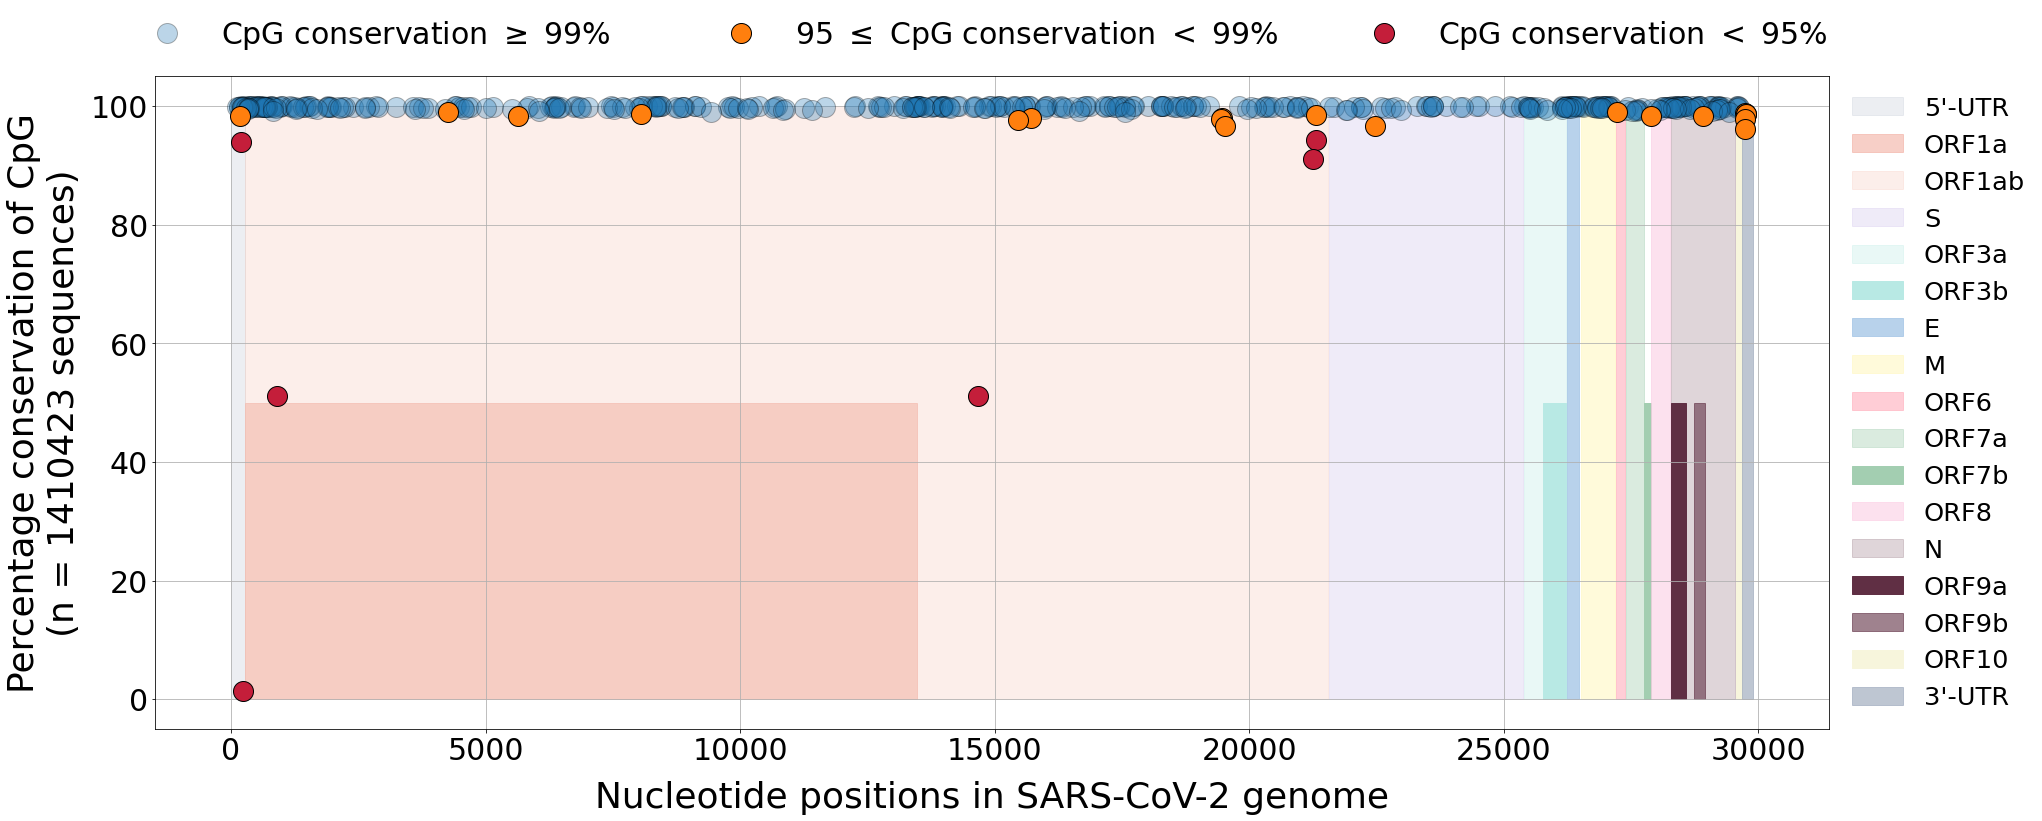

In [17]:
plt.rcParams['figure.figsize'] = (30, 12)
plt.rcParams['axes.facecolor'] = (1,1,1)
plt.rcParams['savefig.facecolor'] = (1,1,1)


fig, ax = plt.subplots()

ax.grid(True)
ax.set_ylabel('Percentage conservation of CpG\n(n = 1410423 sequences)', fontsize=36, labelpad=10)
ax.set_xlabel('Nucleotide positions in SARS-CoV-2 genome', fontsize=36, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=30)

line1, = ax.plot(
    lessthanone['mapping'], lessthanone['percentage'], 
    marker='o', markersize=20 , markeredgecolor='black', 
    linestyle='', 
    alpha=0.3, 
    label=r'CpG conservation $\geq$ 99%'
)

line2, = ax.plot(
    onetofive['mapping'], onetofive['percentage'], 
    marker='o', markersize=20 , markeredgecolor='black', 
    linestyle='', 
    alpha=1, 
    label=r'95 $\leq$ CpG conservation $<$ 99%'
)

line3, = ax.plot(
    morethanfive['mapping'], morethanfive['percentage'], 
    marker='o', markersize=20 , markeredgecolor='black', color='#c41e3a', 
    linestyle='', 
    alpha=1, 
    label=r'CpG conservation $<$ 95%'
)

first_legend = ax.legend(
    handles=[line1], 
    loc=(0.1-0.118,1.02), 
    fontsize=30, 
    frameon=False
)
ax.add_artist(first_legend)

second_legend = ax.legend(
    handles=[line2], 
    loc=(0.5-0.175,1.02), 
    fontsize=30, 
    frameon=False
)
ax.add_artist(second_legend)

third_legend = ax.legend(
    handles=[line3], 
    loc=(0.9-0.191,1.02), 
    fontsize=30, 
    frameon=False
)
ax.add_artist(third_legend)


add_sars_cov2_patches_to_plot(
    ax, legend_location=(1, 1.005), legend_font_size=25.65, ymax=100
)


### Fig. 4.(b) : Gene-wise analysis of CpG loss

Gene-wise analysis of CpG loss: the number of CpGs within each gene is indicated on the x axis. Box-and-whiskers plots show the gene-wise distribution of sequences that lost CpG dinucleotide(s). Outliers are shown as black dots. The extent of CpG depletion varies greatly within and across genes. 


The NSP-wise analysis was done by [Dr. Manoj B. Menon](https://scholar.google.com/citations?user=tRNi_jQAAAAJ&hl=en&oi=ao) and [Dr. Sonam Dhamija](https://scholar.google.com/citations?user=vct7PXQAAAAJ&hl=en&oi=ao) in MS Excel. The results of the analysis were saved as .csv files and we'll create visualizations using those files.

In [18]:
df_num = pd.read_csv('../csv_files/nspwise_cpg_numbers_norm.csv')
df_per = pd.read_csv('../csv_files/nspwise_cpg_percentage_norm.csv')

In [19]:
sns.set_theme(style='white')
sns.set_context(
    'paper', font_scale=1, 
    rc={ 
        'ytick.labelsize': 50, 
        'xtick.labelsize': 50, 
        'axes.edgecolor':0.05, 
        'axes.linewidth':2
    }
)

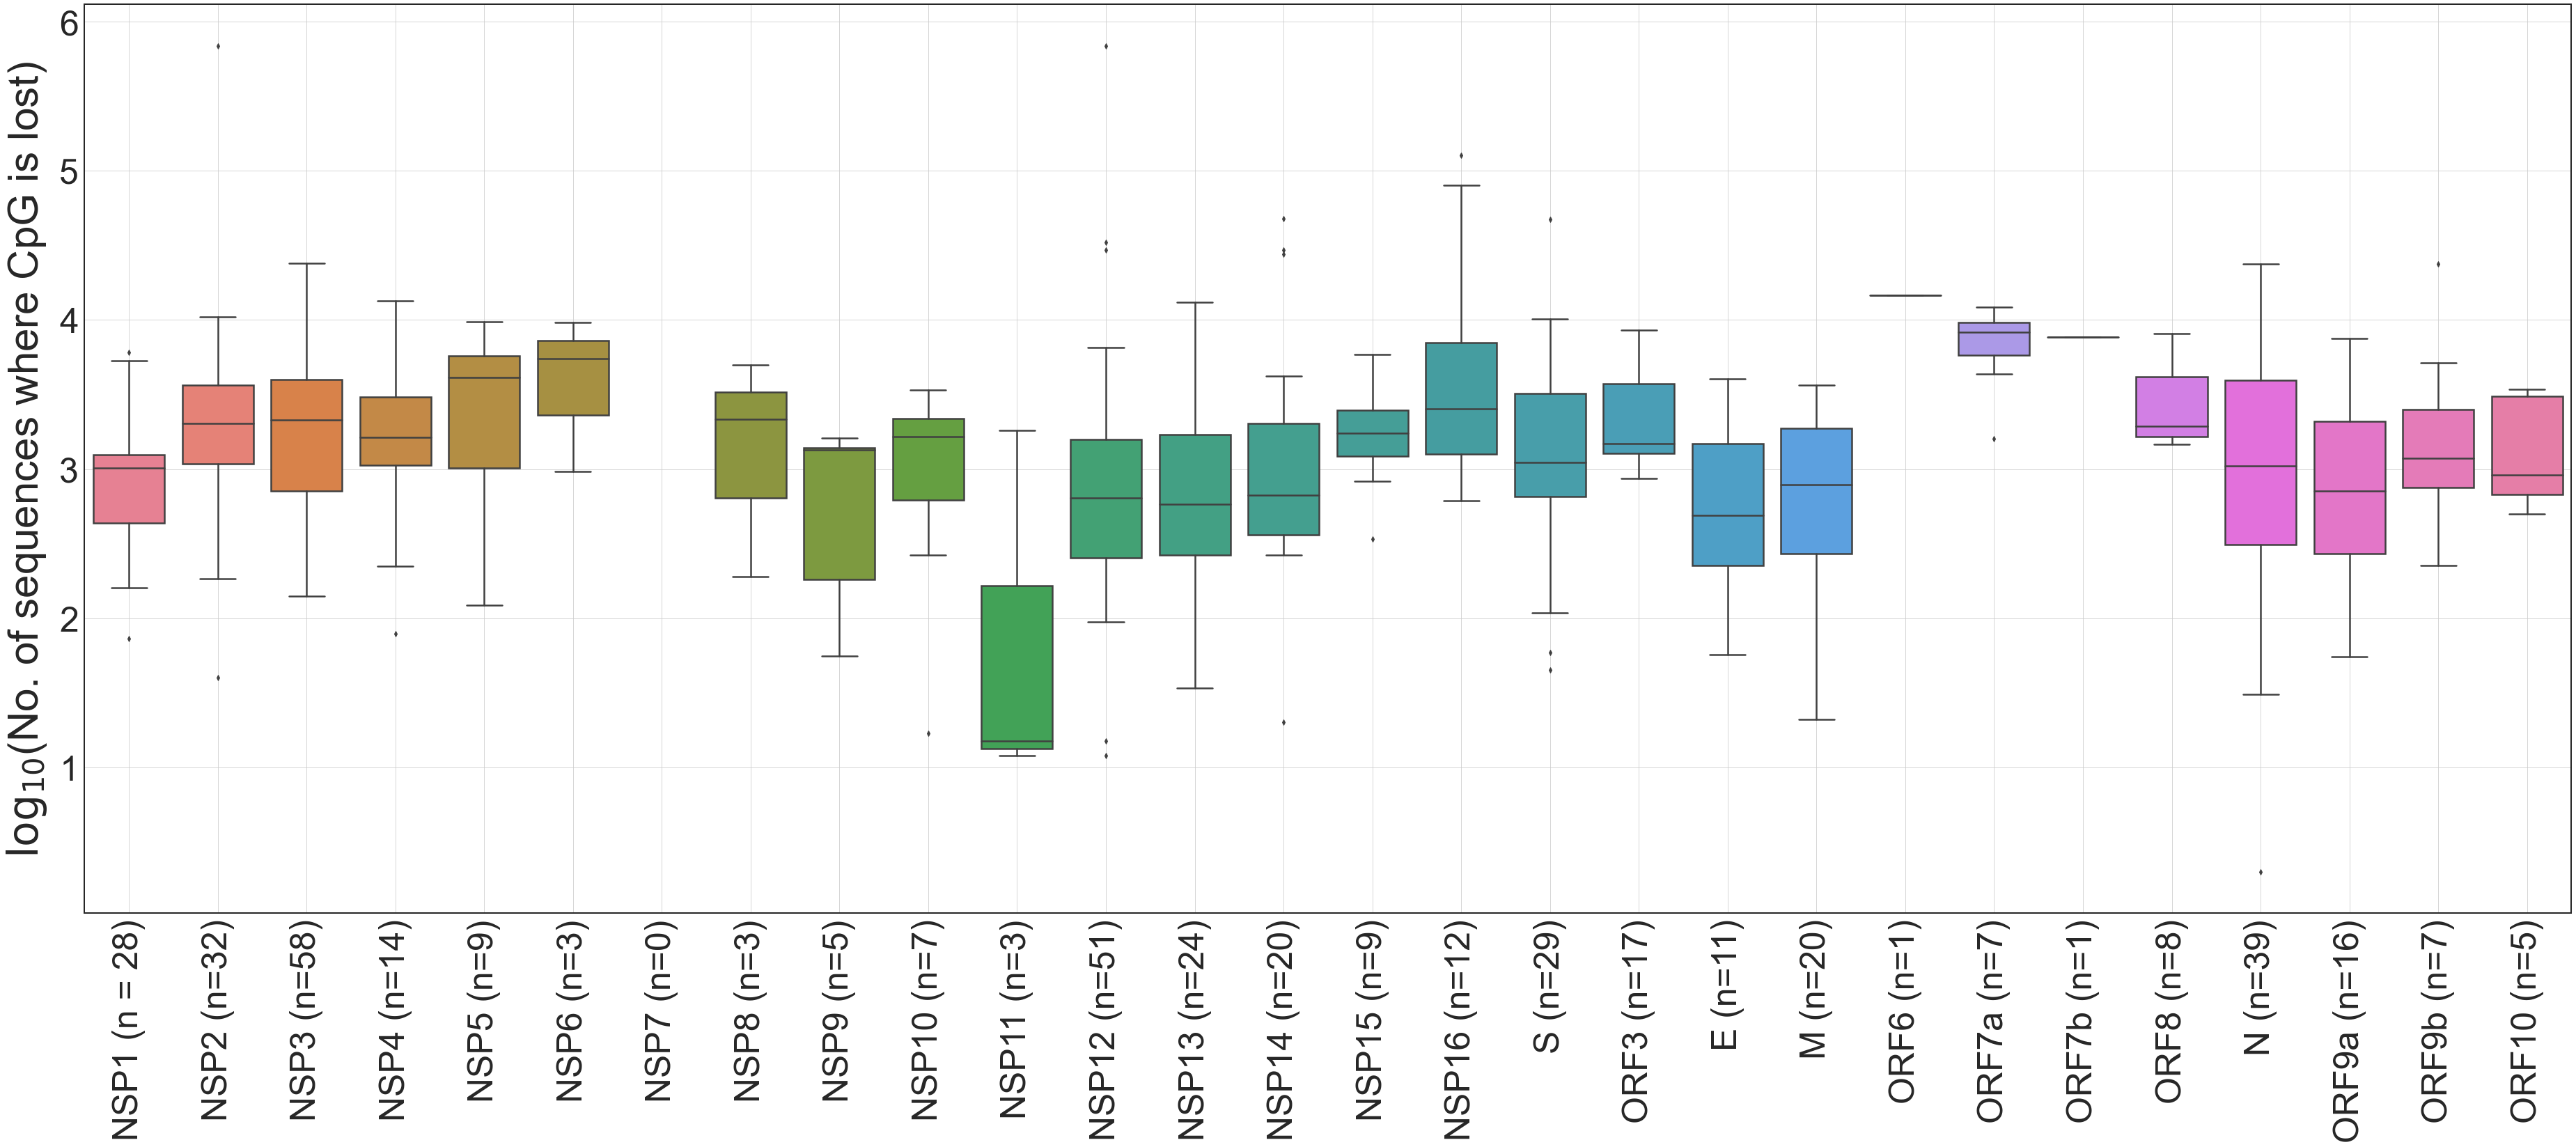

In [20]:
plt.figure(figsize=(64, 24))

# --------------------------------------------------------------------
# Either use this code block -----------------------------------------

df_num_norm = np.log10(df_num)

ax = sns.boxplot(data=df_num_norm, palette='husl', linewidth=2.5)
ax.set_ylabel(
    r'$\log_{10}$(No. of sequences where CpG is lost)', 
    size=60, labelpad=15
)
# ---------------------------------------------------------------------
# # Or this -----------------------------------------------------------

# ax = sns.boxplot(data=df_num, palette='husl', linewidth=2.5)
# ax.set_ylabel(
#     'No. of sequences where CpG is lost', 
#     size = 60, labelpad=15
# )
# ax.set_yscale('log')
# --------------------------------------------------------------------
# --------------------------------------------------------------------

xticklabels_new = [
    item.get_text().replace(' |', '') 
    for item in ax.get_xticklabels()
]
ax.set_xticklabels(xticklabels_new)


plt.xticks(rotation=90)
ax.grid(True)

### Fig. 4.(c)

CpGs within coding regions of SARS-CoV-2 are grouped on the basis of codon positions. The loss of CpGs at codon positions 2-3 and 3-1 is more pronounced than that at codon position 1-2. The Mann–Whitney U test was used to compare the medians in the violin plots. NSP, nonstructural protein; ORF, open reading frame.

In [21]:
df_cpg_pos_12 = pd.read_csv('../csv_files/codon_analysis_12.csv')
df_cpg_pos_12.rename(
    columns={df_cpg_pos_12.columns[0]: 'cpg_numbers'}, inplace=True
)
df_cpg_pos_12 = df_cpg_pos_12.assign(hue='[1-2]')

df_cpg_pos_23 = pd.read_csv('../csv_files/codon_analysis_23.csv')
df_cpg_pos_23.rename(
    columns={df_cpg_pos_23.columns[0]: 'cpg_numbers'}, inplace=True
)
df_cpg_pos_23 = df_cpg_pos_23.assign(hue='[2-3]')

df_cpg_pos_31 = pd.read_csv('../csv_files/codon_analysis_31.csv')
df_cpg_pos_31.rename(
    columns={df_cpg_pos_31.columns[0]: 'cpg_numbers'}, inplace=True
)
df_cpg_pos_31 = df_cpg_pos_31.assign(hue='[3-1]')

df_cpg_pos_12.name = '[1-2]'
df_cpg_pos_23.name = '[2-3]'
df_cpg_pos_31.name = '[3-1]'

#### Mann-Whitney U test (For Fig. 4.(c))

[Mann-Whitney U rank test on two independent samples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of of difference in location between distributions.

Now, we'll conduct Mann-Whitney U test for Fig. 4.(c).

In [22]:
print('Mann-Whitney U test results: ')

m_12_23, p_12_23 =stats.mannwhitneyu(
    df_cpg_pos_12['cpg_numbers'], df_cpg_pos_23['cpg_numbers'], 
    alternative='two-sided', 
    method='auto'
)

print(f'->  For positions {df_cpg_pos_12.name} and {df_cpg_pos_23.name}, m: {m_12_23} and p: {p_12_23}')

m_23_31, p_23_31 =stats.mannwhitneyu(
    df_cpg_pos_23['cpg_numbers'], df_cpg_pos_31['cpg_numbers'], 
    alternative='two-sided', 
    method='auto'
)
print(f'->  For positions {df_cpg_pos_23.name} and {df_cpg_pos_31.name}, m: {m_23_31} and p: {p_23_31}')

m_31_12, p_31_12 =stats.mannwhitneyu(
    df_cpg_pos_31['cpg_numbers'], df_cpg_pos_12['cpg_numbers'], 
    alternative='two-sided', 
    method='auto'
)
print(f'->  For positions {df_cpg_pos_31.name} and {df_cpg_pos_12.name}, m: {m_31_12} and p: {p_31_12}')


Mann-Whitney U test results: 
->  For positions [1-2] and [2-3], m: 2909.0 and p: 1.3046274732436153e-15
->  For positions [2-3] and [3-1], m: 10021.5 and p: 0.28834930118297186
->  For positions [3-1] and [1-2], m: 21899.5 and p: 5.3033636781120866e-18


From the results of Mann-Whitney U tests, we can safely say that p < 0.0001 for CpGs at codon positions:
- [1-2] and [2-3]
- [3-1] and [1-2]

Hence, we'll use p < 0.0001 for their violinplots.

#### Plot

In [23]:
df_fig4c = pd.concat(
    [df_cpg_pos_12, df_cpg_pos_23, df_cpg_pos_31]
)
df_fig4c = df_fig4c.assign(cpg_numbers_norm=np.log10(df_fig4c['cpg_numbers']))
df_fig4c.name = 'Number of sequences where CpG is lost'

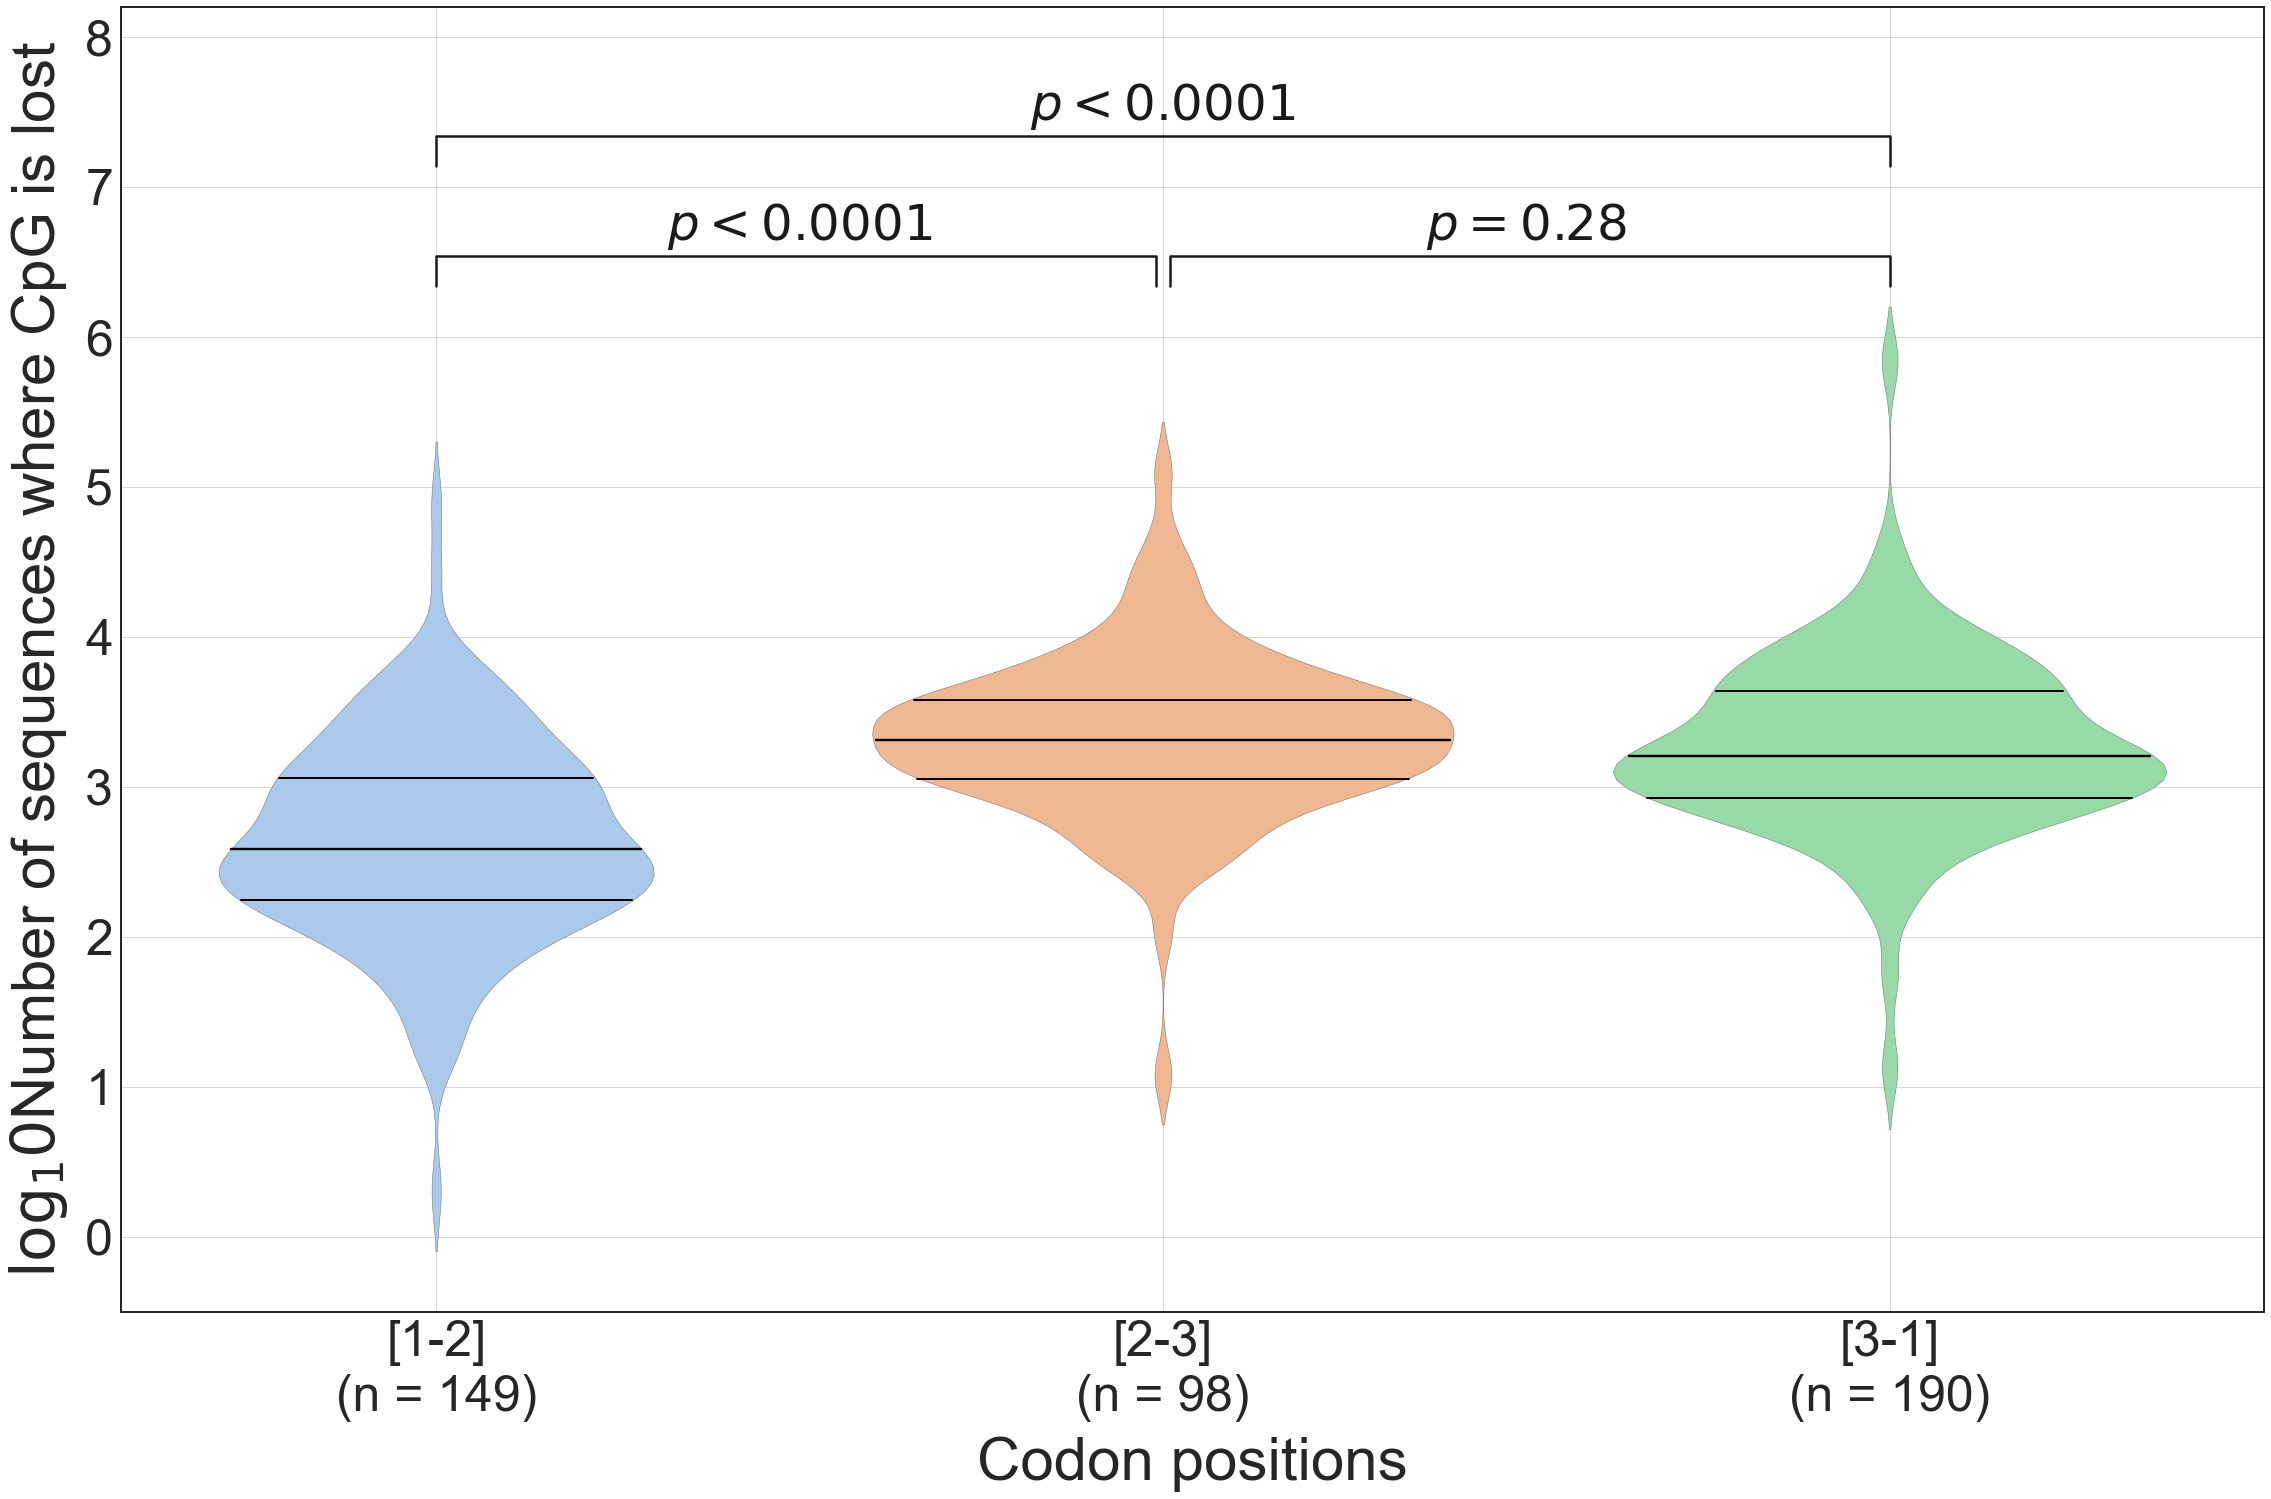

In [24]:
to_plot = df_fig4c

plt.figure(figsize=(16*1.2*2, 24))

ax = sns.violinplot(
    x='hue', y=to_plot['cpg_numbers_norm'], 
    data=to_plot, 
    order=['[1-2]', '[2-3]', '[3-1]'], 
    inner='quartile', 
    linewidth=0.5, bw=0.3, 
    palette='pastel'
)

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(2.4)
    l.set_color('black')
    
# statistical annotation
x1, x2 = 0, 1   
y, h, col = to_plot['cpg_numbers_norm'].max() + .5, .2, 'k'
plt.plot(
    [x1, x1, x2-.01, x2-.01], [y, y+h, y+h, y], 
    lw=2.5, 
    c=col
)
plt.text(
    (x1+x2)*.5, y+h+.03, r'$p < 0.0001$', 
    ha='center', va='bottom', 
    color=col, size=50
)

x1, x2 = 1, 2
y, h, col = to_plot['cpg_numbers_norm'].max() + .5, .2, 'k'
plt.plot(
    [x1+.01, x1+.01, x2, x2], [y, y+h, y+h, y], 
    lw=2.5, 
    c=col
)
# rounding error, it should've been p=0.29
plt.text(
    (x1+x2)*.5, y+h+.03, r'$p = 0.28$', 
    ha='center', va='bottom', 
    color=col, 
    size=50
)

x1, x2 = 0, 2   
y, h, col = to_plot['cpg_numbers_norm'].max() + 1.3, .2, 'k'
plt.plot(
    [x1, x1, x2, x2], [y, y+h, y+h, y], 
    lw=2.5, 
    c=col
)
plt.text(
    (x1+x2)*.5, y+h+.03, r'$p < 0.0001$', 
    ha='center', va='bottom', 
    color=col, 
    size=50
)


ax.set_xticklabels(
    [
        '[1-2]''\n'f'(n = {len(df_cpg_pos_12)})', 
        '[2-3]''\n'f'(n = {len(df_cpg_pos_23)})', 
        '[3-1]''\n'f'(n = {len(df_cpg_pos_31)})'
    ]
)
ax.set_ylabel(rf'$\log_{10}${to_plot.name}', size=60, labelpad=15)
ax.set_xlabel('Codon positions', size = 60, labelpad=15)
ax.set_ylim(-.5,8.2)
ax.grid(True)


# Saving the dataframes and supplementary tables

## Saving Supplementary Table 6

In [25]:
supp_table_06 = pd.concat(
    [
        lessthanone[['mapping', 'percentage']], 
        onetofive[['mapping', 'percentage']], 
        morethanfive[['mapping', 'percentage']]
    ]
).sort_values(by='percentage'
).reset_index(drop=True
)

supp_table_06.rename(columns={'mapping': 'CpG dinucleotide position',
                              'percentage': 'Percentage conservation'}, inplace=True)
# supp_table_06.to_excel('../supplementary_tables/Supplementary Table 6.xlsx',
#                        index=False, sheet_name='Figure 4A data')
supp_table_06.head()

,CpG dinucleotide position,Percentage conservation
0,241,1.304006
1,14676,51.065886
2,913,51.098217
3,21254,91.030421
4,203,93.938202


## Saving dataframes